In [18]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as skpp
# XGBoost
# https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn
import xgboost as xgb # must be in AMN_windows env
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.multioutput import MultiOutputRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, Tuple, List


# PATH = "biolog_metabolic_genes_single_only.csv"
# PATH = "biolog_metabolic_genes.csv"
PATH = "biolog_metabolic_genes_low_std.csv"

all_data = pd.read_csv(PATH, index_col=0)
# all_data_norm = (all_data - all_data.mean()) - all_data.std()
all_data

,Experiment Description,Data Definition,Well Substrate,Data Value,Data Submitter
0,b3091 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,0.780000,Blattner Laboratory
1,b3093 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,1.430000,Blattner Laboratory
2,b3132 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,1.040000,Blattner Laboratory
3,b3137 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,1.090000,Blattner Laboratory
4,b3161 mutant Biolog assay,OD600 growth,(-)Shikimic Acid,0.910000,Blattner Laboratory
...,...,...,...,...,...
15348,b3543 mutant Biolog assay,OD600 growth,D-Glucose-6-Phosphate,1.270000,Blattner Laboratory
15349,b3543 mutant Biolog assay,OD600 growth,L-Asparagine,1.410000,Blattner Laboratory
15350,b3543 mutant Biolog assay,OD600 growth,D-Serine,1.215000,Blattner Laboratory
15351,b3543 mutant Biolog assay,OD600 growth,D-Alanine,1.836667,Blattner Laboratory


<AxesSubplot:xlabel='Data Value', ylabel='Count'>

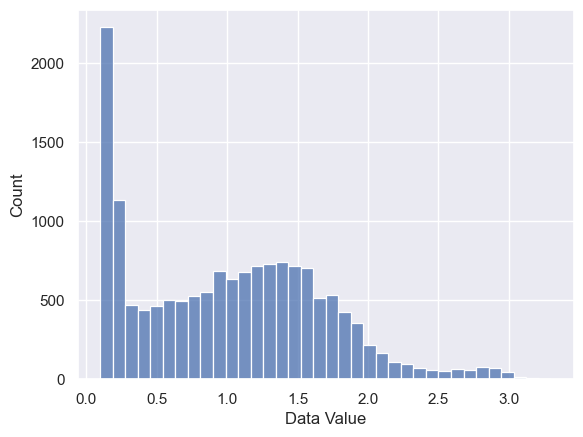

In [19]:
plt.close('all')
sns.set_theme()
sns.histplot(all_data["Data Value"])

In [20]:
print("Unique mutants number: ", len(set(all_data['Experiment Description'])))
print("Unique substrates number: ", len(set(all_data['Well Substrate'])))

Unique mutants number:  120
Unique substrates number:  149


In [21]:
target_gene_encoder = skpp.OneHotEncoder()
which_CS_encoder = skpp.OneHotEncoder()

raw_target_gene = all_data["Experiment Description"].values.reshape(-1, 1)
raw_which_medium = all_data["Well Substrate"].values.reshape(-1, 1)

target_gene_encoder.fit(raw_target_gene)
which_CS_encoder.fit(raw_which_medium)

X_left = target_gene_encoder.transform(raw_target_gene).toarray()
X_right = which_CS_encoder.transform(raw_which_medium).toarray()

X = np.hstack((X_left, X_right))

# raw_X = all_data.iloc[:,:3].values
# enc.fit(raw_X)
# X = enc.transform(raw_X).toarray()

Y = all_data["Data Value"].values.reshape(-1, 1)
print(X.shape, Y.shape)

(15353, 269) (15353, 1)


In [22]:
LOO_split = int(Y.shape[0])

xgb_preds = []

for i in range(1):

    # XGBoost = xgb.XGBRegressor(n_estimators=600, max_depth=2, learning_rate=0.01, objective='reg:squarederror', random_state=i)

    multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror'))
    
    xgb_pred = cvp(multioutputregressor, X, Y, cv=KFold(n_splits=10, shuffle=True, random_state=i), n_jobs=10)
    
    xgb_preds.append(xgb_pred)

In [23]:
xgb_preds

[array([[1.0535468],
        [1.1161952],
        [1.0646251],
        ...,
        [1.2608982],
        [1.4591802],
        [1.1094887]], dtype=float32)]

In [24]:
mean_xgb_pred = np.array(xgb_preds).mean(axis=0)
std_xgb = np.array(xgb_preds).std(axis=0)

print("Mean squared error between mean prediction and true fluxes", np.mean((mean_xgb_pred - Y)**2, axis=0))
# MSE between mean prediction (over 5 times 10-fold test sets) and true

print("Q²: ", r2_score(Y, mean_xgb_pred))

Mean squared error between mean prediction and true fluxes [0.11753889]
Q²:  0.739352712972696


all data: 

Mean squared error between mean prediction and true fluxes [0.10932903]
Q²:  0.729

only single:

Mean squared error between mean prediction and true fluxes [0.12198846]
Q²:  0.730201885417885

low_std:

Mean squared error between mean prediction and true fluxes [0.11753889]
Q²:  0.739352712972696

<AxesSubplot:ylabel='Count'>

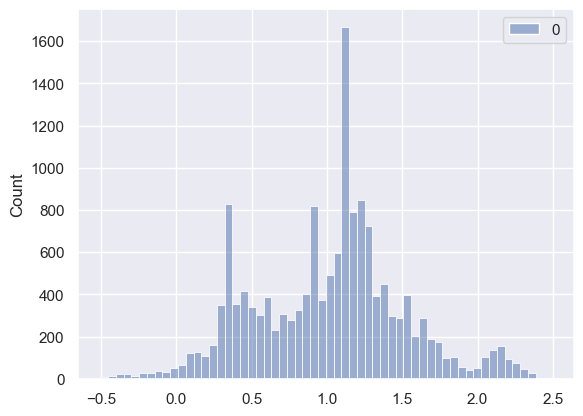

In [25]:
sns.histplot(mean_xgb_pred)